<h1>The Battle of Neighbourhoods (Part-1)</h1>

<h2> Introduction </h2>

<p>New York is the largest city in the United states with a lot of immigration. The population of New York city was close to 8.5 million in 2014. The large portion of these immigrants includes Chinese, Indians and French.  This is a hypothetic project to identify the potential clusters of area having Indian restaurants to determine which areas would be better to open new Indian restaurants. </p>

<p>By using data science methods and tools along with the machine learning algorithms such as clustering, the project aims to provide solution to answer few business considerations.</p>

<h2>Target Audience</h2> 
The entrepreneur who wants to find the location to open Indian restaurant in New York. 

<h2>Data</h2>
<p> To solve the problem, following data is needed</p>

1.	Lists of neighbourhoods in New York.
2.	Latitude and longitude of these neighbourhoods
3.	Data related to venue of different restaurants to identify which area should be suitable for opening an Indian restaurant.

<h2>Problem Statements:</h2>

1.	Identify and visualize all major neighbourhoods of New York City having great Indian restaurants. 
2.	To determine the best location in New York city for Indian restaurant.
3.	Areas having potential to have Indian restaurant.
4.	The areas which are having less or no Indian restaurant
5.	The best place in New York for Indian cuisine.

Lets First import the required Libraries.


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 102kB 7.4MB/s ta 0:00:011
     |████████████████████████████████| 102kB 8.9MB/s ta 0:00:011
Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Now lets define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres. 
Below function will return us the venue id , venue name and category.

In [87]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'AU4UWCYFELBAXLJ0O5ZJRLWI0J4TK1DKCDPI0WXX4HKJ0UC3' # your Foursquare ID
    CLIENT_SECRET = 'P1BMJXI3E1HF4UORMEEAXIBXSKNZMXNZSIYJBCCT0IRRYV4A' # your Foursquare Secret
    VERSION = '20200702' # Foursquare API version
            
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    
  
    ##url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
   ## url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&oauth_token={}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
    
    # get all the data
    results = requests.get(url, "none").json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now define a function to get venue details for ranking.

In [88]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'AU4UWCYFELBAXLJ0O5ZJRLWI0J4TK1DKCDPI0WXX4HKJ0UC3' # your Foursquare ID
    CLIENT_SECRET = 'P1BMJXI3E1HF4UORMEEAXIBXSKNZMXNZSIYJBCCT0IRRYV4A' # your Foursquare Secret
    VERSION = '20200702' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now define a funtion to get the city data.

In [12]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Now call the funtion to get the new york city data

In [6]:
new_york_data=get_new_york_data()
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

Lets show different Neighborhoods in New York in BAR PLOT

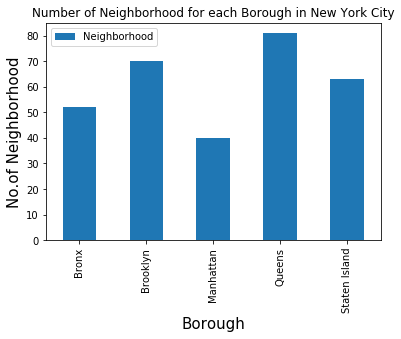

In [8]:
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h3> As per the above Bar Plot,Queens has highest number of neighborhoods </h3>

Lets collect Indian resturants for each Neighborhood.

In [76]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [77]:
indian_rest_ny.head(5)

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [78]:
indian_rest_ny.shape

(148, 4)

<h2> From the above result, we see that there are 151 Indian Resturants across New York City </h2>

Now let create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City.

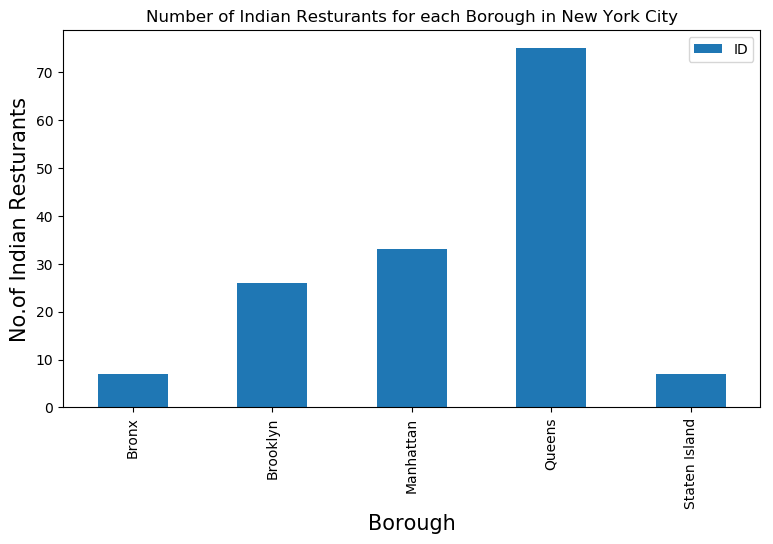

In [79]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<h2> From the above Bar Plot, we can see that Queens has highest number of Indian resturants </h2>

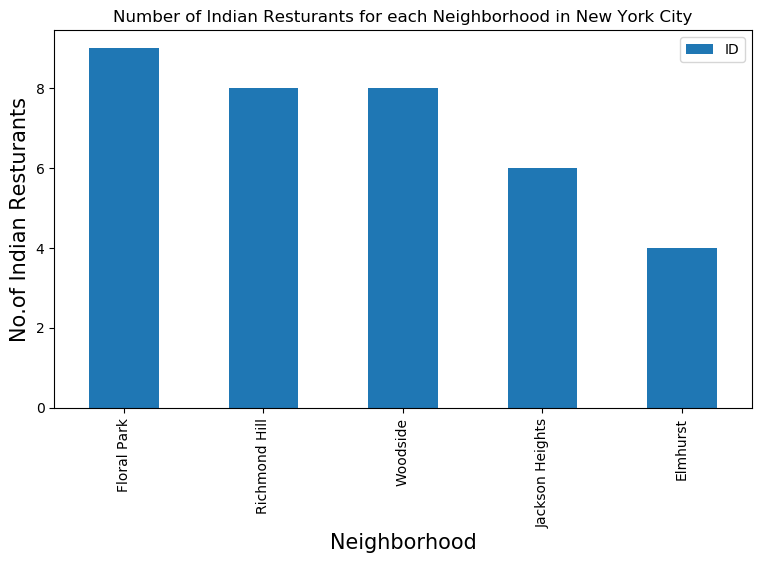

In [80]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [81]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
107,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
108,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
109,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
110,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
111,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
112,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
113,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
114,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
115,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


<h2> We can see that, Floral Park in Queens has the highest number of Indian Resturants with a total count of 9 </h2>

Now we will get the ranking of each resturant for further analysis.

In [89]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.1    10
( 1 / 148 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 2 / 148 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 3 / 148 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.0     3
( 4 / 148 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 5 / 148 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 148 ) processed
                         ID       Name  Likes  Rat

In [90]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.1,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2


In [91]:
indian_rest_stats_ny.shape

(148, 7)

In [92]:
indian_rest_ny.shape

(148, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [93]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [94]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [95]:
indian_rest_stats_ny_csv.shape

(148, 7)

In [96]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.1,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2


In [97]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
Borough         148 non-null object
Neighborhood    148 non-null object
ID              148 non-null object
Name            148 non-null object
Likes           148 non-null object
Rating          148 non-null float64
Tips            148 non-null object
dtypes: float64(1), object(6)
memory usage: 8.2+ KB


In [98]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [99]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
Borough         148 non-null object
Neighborhood    148 non-null object
ID              148 non-null object
Name            148 non-null object
Likes           148 non-null float64
Rating          148 non-null float64
Tips            148 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips

In [100]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               8.9
Tips                                 148
Name: 44, dtype: object

In [101]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                240
Rating                                 9
Tips                                 133
Name: 55, dtype: object

In [102]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [103]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
5,Blissville,9.00
61,Sunnyside,9.00
12,Civic Center,8.90
70,West Village,8.90
29,Greenwich Village,8.90
65,Tribeca,8.90
23,Fort Greene,8.80
49,Prospect Heights,8.70
0,Astoria,8.65
63,Sutton Place,8.50


<h2> Above are the top neighborhoods with top average rating of Indian resturants. </h2>
Similarly we will find the average rating of Indian Resturants for each Borough.

In [104]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [105]:

ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.239394
1,Brooklyn,7.680769
3,Queens,6.609333
0,Bronx,5.671429
4,Staten Island,4.514286


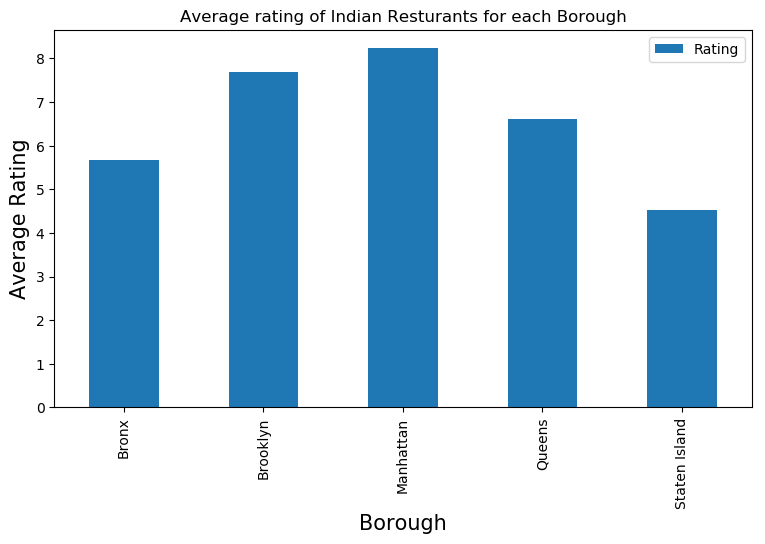

In [106]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [107]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [108]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Blissville,9.0
61,Sunnyside,9.0


We will join this dataset to original new york data to get lonitude and latitude.

In [109]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [110]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [111]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Blissville,40.737251,-73.932442,9.0
1,Queens,Sunnyside,40.740176,-73.926916,9.0
2,Staten Island,Sunnyside,40.612760,-74.097126,9.0


Finally, Let's show this data on a map.

In [112]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [113]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [114]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [115]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average Rating.

<h2> Conclusion: </h2>
<p>So now we can answer the questions asked above in the Questions section of the notebook. </p>
<p>From our anaysis the answers to the above questions are: </p>
    A1) Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for Indian cuisine.
    A2) Manhattan have potential Indian Resturant Market.
    A3) Staten Island ranks last in average rating of Indian Resturants.
    A4) Manhattan is the best place to stay if you prefer Indian Cuisine